# BDT optimization for the analysis of $\tau^+\tau^- \to (\pi^+ \nu_{\tau})(\pi^- \nu_{\tau})$ 

In [1]:
from ROOT import TFile, TCanvas, TPad, TChain, TLegend, TTree, TString, TList, TCut
from ROOT import kGreen, kBlue, kRed, kBlack, kOrange, kGreen, kCyan, kMagenta, kAzure
from ROOT import TH1D, TVector3, TLorentzVector, TGraph, TMath, TFeldmanCousins
from ROOT import TMVA
import numpy as np
import random
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from array import array
import matplotlib.pyplot as plt

Welcome to JupyROOT 6.20/04


Let's get the data from ROOT files

In [2]:
chtausig = TChain("tau1x1")
chtaupair= TChain("tau1x1")
chuubar= TChain("tau1x1")
chddbar= TChain("tau1x1")
chccbar= TChain("tau1x1")
chssbar= TChain("tau1x1")
chcharged = TChain("tau1x1")
chmixed = TChain("tau1x1")
chee = TChain("tau1x1")
cheeee1 = TChain("tau1x1")
cheeee2 = TChain("tau1x1")
cheeee3 = TChain("tau1x1")
chmumu1 = TChain("tau1x1")
chmumu2 = TChain("tau1x1")
cheemumu1 = TChain("tau1x1")
cheemumu1_1 = TChain("tau1x1")
cheemumu2 = TChain("tau1x1")




myworkdir = "/storage/jcolorado/Belle2/data/"
chtausig.AddFile(myworkdir+"tau1x1_pinu_cuts.root")
chtaupair.AddFile(myworkdir+"tau1x1_bkg_cuts.root")
chuubar.AddFile(myworkdir+"uubar1x1_pinu_cuts.root")
chddbar.AddFile(myworkdir+"ddbar1x1_pinu_cuts.root")
chssbar.AddFile(myworkdir+"ssbar1x1_pinu_cuts.root")
chccbar.AddFile(myworkdir+"ccbar1x1_pinu_cuts.root")
chcharged.AddFile(myworkdir+"charged1x1_pinu_cuts.root")
chmixed.AddFile(myworkdir+"mixed1x1_pinu_cuts.root")
chee.AddFile(myworkdir+"tau1x1_ee_cuts.root")
cheeee1.AddFile(myworkdir+"tau1x1_eeee1_cuts.root")
cheeee2.AddFile(myworkdir+"tau1x1_eeee2_cuts.root")
cheeee3.AddFile(myworkdir+"tau1x1_eeee3_cuts.root")
chmumu1.AddFile(myworkdir+"tau1x1_mumu1_cuts.root")
chmumu2.AddFile(myworkdir+"tau1x1_mumu2_cuts.root")
cheemumu1.AddFile(myworkdir+"tau1x1_eemumu1_cuts.root")
cheemumu1_1.AddFile(myworkdir+"tau1x1_eemumu1_1_cuts.root")
cheemumu2.AddFile(myworkdir+"tau1x1_eemumu2_cuts.root")





print("Signal events     : ",chtausig.GetEntries())
print("Background events :", chtaupair.GetEntries()+chuubar.GetEntries()+chddbar.GetEntries()
      +chssbar.GetEntries()+chccbar.GetEntries()+chcharged.GetEntries()+chmixed.GetEntries()+chee.GetEntries()
      +chee.GetEntries()+cheeee1.GetEntries()+cheeee2.GetEntries()+cheeee3.GetEntries()+chmumu1.GetEntries()
      +chmumu2.GetEntries()+cheemumu1.GetEntries()+cheemumu1_1.GetEntries()
      +cheemumu2.GetEntries())

Signal events     :  476464
Background events : 204101801


Let's prepare data for BDT

In [3]:
sigTree = TTree("sigTree","Signal Tree")
bkgTree = TTree("bkgTree","Background Tree")

leafsall = ["track1__cosToThrustOfEvent","track2__cosToThrustOfEvent","track1__clusterE","track2__clusterE",
            "visibleEnergyOfEventCMS","missingMomentumOfEventCMS",
         "missingMomentumOfEventCMS_theta",
         "missingMass2OfEvent","track1__EoverP",
         "track2__EoverP","track1__pt","track2__pt","track1__pionID","track2__pionID",
            "track1__p","track2__p"]

chtausig.SetBranchStatus("*", 0)
chtaupair.SetBranchStatus("*", 0)
chuubar.SetBranchStatus("*", 0)
chddbar.SetBranchStatus("*", 0)
chssbar.SetBranchStatus("*", 0)
chccbar.SetBranchStatus("*", 0)
chcharged.SetBranchStatus("*", 0)
chmixed.SetBranchStatus("*", 0)

for lf in leafsall:
    chtausig.SetBranchStatus(lf, 1)
    chtaupair.SetBranchStatus(lf, 1)
    chuubar.SetBranchStatus(lf, 1)
    chddbar.SetBranchStatus(lf, 1)
    chssbar.SetBranchStatus(lf, 1)
    chccbar.SetBranchStatus(lf, 1)
    chcharged.SetBranchStatus(lf, 1)
    chmixed.SetBranchStatus(lf, 1)

npart = 5 #We use 10% of data for Training and 10% for Testing (randomly selected)

sigTree = chtausig.CopyTree("","",int(chtausig.GetEntries()/npart),0)
bkg1 =    chtaupair.CopyTree("","",int(chtaupair.GetEntries()/npart),0) 
bkg2 =    chuubar.CopyTree("","",int(chuubar.GetEntries()/npart),0) 
bkg3 =    chddbar.CopyTree("","",int(chddbar.GetEntries()/npart),0) 
bkg4 =    chssbar.CopyTree("","",int(chssbar.GetEntries()/npart),0) 
bkg5 =    chccbar.CopyTree("","",int(chccbar.GetEntries()/npart),0) 
bkg6 =    chcharged.CopyTree("","",int(chcharged.GetEntries()/npart),0) 
bkg7 =    chmixed.CopyTree("","",int(chmixed.GetEntries()/npart),0) 

treelist = TList()
treelist.Add(bkg1)
treelist.Add(bkg2)
treelist.Add(bkg3)
treelist.Add(bkg4)
treelist.Add(bkg5)
treelist.Add(bkg6)
treelist.Add(bkg7)

bkgTree = TTree.MergeTrees(treelist)

print("Signal events     : ",sigTree.GetEntries())
print("Background events :",bkgTree.GetEntries())

Signal events     :  95292
Background events : 1498232


BDT implementation and optimization

In [4]:
rootfile = TFile("tmva_out_bdt.root","RECREATE")
tmvafactory = TMVA.Factory("",rootfile,"AnalysisType=Classification")
dloader = TMVA.DataLoader("dataset")

for lf in leafsall:
    dloader.AddVariable(lf,'F')
    
dloader.AddSignalTree(sigTree,1.0)
dloader.AddBackgroundTree(bkgTree,1.0)

signalCut = TCut("")
backgroundCut = TCut("")
datasetOptions = TString("SplitMode=Random")
dloader.PrepareTrainingAndTestTree(signalCut,backgroundCut,datasetOptions)

methodOptions=TString("NTrees=100:BoostType=AdaBoost:SeparationType=GiniIndex:nCuts=20:PruneMethod=CostComplexity:PruneStrength=4.5")

tmvafactory.BookMethod(dloader,TMVA.Types.kBDT,"BDT",methodOptions)
tmvafactory.TrainAllMethods()
tmvafactory.TestAllMethods()
tmvafactory.EvaluateAllMethods()

rootfile.Close()

create data set info dataset
<HEADER> DataSetInfo              : [dataset] : Added class "Signal"
                         : Add Tree tau1x1 of type Signal with 95292 events
<HEADER> DataSetInfo              : [dataset] : Added class "Background"
                         : Add Tree tau1x1 of type Background with 1498232 events
<HEADER> Factory                  : Booking method: BDT
                         : 
                         : Building event vectors for type 2 Signal
                         : Dataset[dataset] :  create input formulas for tree tau1x1
                         : Building event vectors for type 2 Background
                         : Dataset[dataset] :  create input formulas for tree tau1x1
<HEADER> DataSetFactory           : [dataset] : Number of events in input trees
                         : 
                         : 
                         : Dataset[dataset] : Weight renormalisation mode: "EqualNumEvents": renormalises all event classes ...
             

1%, time left: unknown
8%, time left: 65 sec
14%, time left: 59 sec
20%, time left: 54 sec
26%, time left: 50 sec
33%, time left: 45 sec
39%, time left: 41 sec
45%, time left: 37 sec
51%, time left: 33 sec
58%, time left: 28 sec
64%, time left: 24 sec
70%, time left: 20 sec
76%, time left: 16 sec
83%, time left: 11 sec
89%, time left: 7 sec
95%, time left: 3 sec
0%, time left: unknown
6%, time left: 3 sec
12%, time left: 3 sec
18%, time left: 2 sec
25%, time left: 2 sec
31%, time left: 2 sec
37%, time left: 2 sec
43%, time left: 1 sec
50%, time left: 1 sec
56%, time left: 1 sec
62%, time left: 1 sec
68%, time left: 1 sec
75%, time left: 0 sec
81%, time left: 0 sec
87%, time left: 0 sec
93%, time left: 0 sec
0%, time left: unknown
6%, time left: 3 sec
12%, time left: 2 sec
18%, time left: 2 sec
25%, time left: 2 sec
31%, time left: 2 sec
37%, time left: 2 sec
43%, time left: 1 sec
50%, time left: 1 sec
56%, time left: 1 sec
62%, time left: 1 sec
68%, time left: 1 sec
75%, time left: 0 s

In [5]:
trainT = TChain("TrainTree")
testT = TChain("TestTree")

trainT.Add("tmva_out_bdt.root/dataset/TrainTree")
testT.Add("tmva_out_bdt.root/dataset/TestTree")

print(" Train entries : ",trainT.GetEntries())
print(" Test  entries : ",testT.GetEntries())

 Train entries :  796762
 Test  entries :  796762


Info in <TCanvas::MakeDefCanvas>:  created default TCanvas with name c1


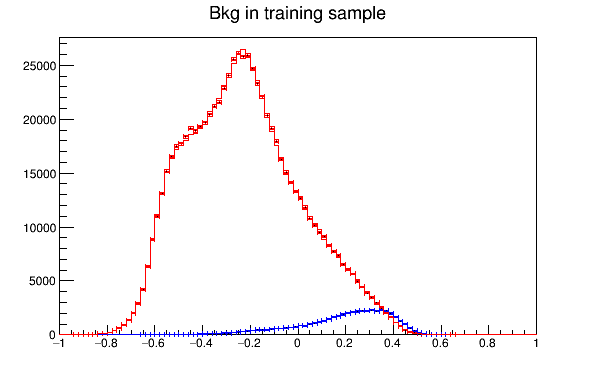

In [6]:
hTrainS = TH1D("hTrainS","Signal in training sample",100,-1,1)
hTrainB = TH1D("hTrainB","Bkg in training sample",100,-1,1)

hTestS = TH1D("hTestS","Signal in test sample",100,-1,1)
hTestB = TH1D("hTestB","Bkg in test sample",100,-1,1)

trainT.Draw("BDT>>hTrainS","classID==0")
trainT.Draw("BDT>>hTrainB","classID==1")

testT.Draw("BDT>>hTestS","classID==0")
testT.Draw("BDT>>hTestB","classID==1")

#hTrainS.Scale(1/hTrainS.GetEntries())
#hTrainB.Scale(1/hTrainB.GetEntries())

#hTestS.Scale(1/hTestS.GetEntries())
#hTestB.Scale(1/hTestB.GetEntries())

hTrainS.SetStats(0)
hTrainB.SetStats(0)
hTestS.SetStats(0)
hTestB.SetStats(0)

hTrainS.SetLineColor(kBlue)
hTrainB.SetLineColor(kRed)
hTestS.SetLineColor(kBlue)
hTestB.SetLineColor(kRed)


cBDT = TCanvas("cBDT", "", 600, 400)
cBDT.cd()
hTrainB.Draw("E1")
hTrainS.Draw("E1 same")
hTestS.Draw("HIST same")
hTestB.Draw("HIST same")
cBDT.Draw()

116.16610323118755   0.19999999999999996  : maximum at x =  0.19999999999999996


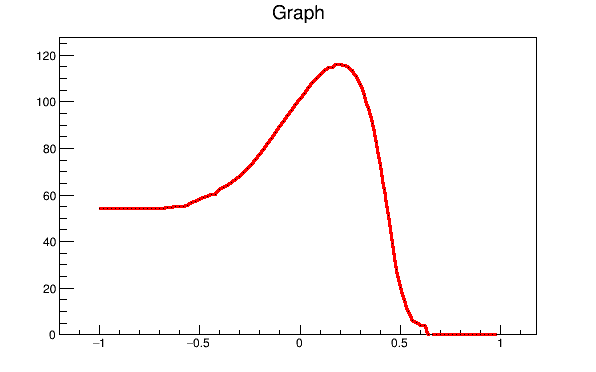

In [7]:
bdtmax = 1.0
bdtmin = -1.0
nbins = 100
binsize = (bdtmax - bdtmin)/nbins

psampling = [bdtmin + i*binsize for i in range(nbins)]

apar = 5
x, y, z = array('d'),array('d'),array('d')

for i in range(len(psampling)):
    xbinB = hTestB.GetXaxis().FindBin(psampling[i])
    xbinS = hTestS.GetXaxis().FindBin(psampling[i])
    nbkg = hTestB.Integral(xbinB,100)
    nsig = hTestS.Integral(xbinS,100)
    FOM = 2*(np.sqrt(nsig+nbkg)-np.sqrt(nbkg))
    
    x.append(psampling[i])
    y.append(FOM)

gFOM = TGraph(len(psampling),x,y)
gFOM.SetLineColor(kRed)
gFOM.SetLineWidth(3)

cP = TCanvas("cP", "", 600, 400)
gFOM.Draw("ACP")
cP.cd()
cP.Draw()

#Let's find the maximum
ymaxval = np.amax(y)
x_at_max_array = np.where(y==np.amax(y))
x_at_max = x[int(x_at_max_array[0])]
print(ymaxval, " ",x_at_max," : maximum at x = ",x_at_max)